<a href="https://colab.research.google.com/github/parmarsuraj99/COMP8730_research_project/blob/main/COMP8730_proposed_solution_step2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install transformers==4.18.0
!pip install datasets==2.0.0
!pip install apache_beam==2.37.0
!pip install sentencepiece==0.1.96
!pip install wandb

In [ ]:
!git clone https://github.com/parmarsuraj99/COMP8730_research_project

Cloning into 'COMP8730_research_project'...
remote: Enumerating objects: 32, done.
remote: Counting objects: 100% (32/32), done.
remote: Compressing objects: 100% (23/23), done.
remote: Total 32 (delta 10), reused 19 (delta 4), pack-reused 0
Unpacking objects: 100% (32/32), done.


In [ ]:
%cd /content/COMP8730_research_project

/content/COMP8730_research_project


In [ ]:
!unzip /content/COMP8730_research_project/inltk_wikipedia/inltk_wikipedia.zip

In [ ]:
import glob 

train_files = glob.glob("train/train/*.txt")
valid_files = glob.glob("valid/valid/*.txt")

In [ ]:
with open('/content/COMP8730_research_project/inltk_cated_train.txt', 'w') as outfile:
    for fname in train_files:
        with open(fname) as infile:
            for line in infile:
                outfile.write(line)

with open('/content/COMP8730_research_project/inltk_cated_valid.txt', 'w') as outfile:
    for fname in valid_files:
        with open(fname) as infile:
            for line in infile:
                outfile.write(line)

In [ ]:
with open("inltk_cated_train.txt", "r") as fp:
    txt = fp.readlines()

In [ ]:
import random
import re

import gc

from datasets import load_dataset
import tensorflow_datasets as tfds

from sklearn.model_selection import train_test_split

random.seed(0)
print(random.random())

def save_list_to_txt(fname: str, arr: list):
    """
    Append new line ('\n') to end of string and save the list in a txt file
    :param fname: filename to load
    :param arr: array to save
    """
    with open(fname, "w") as fp:
        fp.writelines([a + "\n" for a in arr])

def load_inltk_wiki() -> list:
    """
    Loads OSCAR dataset for Sanskrit using HuggingFace datasets

    :return: list of str
    """
    with open("inltk_cated_train.txt", "r") as fp:
        text = fp.readlines()
    text = [t.replace("\n", "") for t in text]
    save_list_to_txt("inltk_wiki_train.txt", text)

    with open("inltk_cated_train.txt", "r") as fp:
        text = fp.readlines()
    text = [t.replace("\n", "") for t in text]
    save_list_to_txt("inltk_wiki_valid.txt", text)

load_inltk_wiki()

print(txt[:100])
gc.collect()


## LM training

- Trains two models and saves them to GDrive

In [ ]:
import random
random.seed(0)

In [ ]:
# saving to GDRive for later use
# Comment if not planning to use GDrive
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!python load_save_lm_dataset.py

In [ ]:
!python train_model.py --wandb true

In [ ]:
!cp -r /content/COMP8730_research_project/results_scratch_False /content/drive/MyDrive/COMP8730_NLPU/results_scratch_false/

In [ ]:
!python train_model.py --from_scratch true --wandb true

In [ ]:
!cp -r /content/COMP8730_research_project/results_scratch_True /content/drive/MyDrive/COMP8730_NLPU/results_scratch_true/

## Author prediction training

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import random
random.seed(0)

In [ ]:
%cd /content/COMP8730_research_project

/content/COMP8730_research_project


In [ ]:
!cp -r /content/drive/MyDrive/COMP8730_NLPU/results_scratch_true/ /content/COMP8730_research_project/results_scratch_True
!cp -r /content/drive/MyDrive/COMP8730_NLPU/results_scratch_false/ /content/COMP8730_research_project/results_scratch_False

In [ ]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

def prepare_csv(file_dir="inltk_sanskrit_shlokas_dataset"):

    df = pd.read_csv(f"{file_dir}/train.csv")
    df_test = pd.read_csv(f"{file_dir}/valid.csv")

    train_ = df.copy()
    test_ = df_test.copy()

    enc = LabelEncoder()
    train_["Class"] = enc.fit_transform(df["Class"])
    test_["Class"] = enc.transform(df_test["Class"])

    train_.rename(columns={"Class": "label", "Sloka":"text"}, inplace=True)
    test_.rename(columns={"Class": "label", "Sloka":"text"}, inplace=True)

    train_["text"] = train_["text"].str.replace(' +', ' ')
    test_["text"] = test_["text"].str.replace(' +', ' ')

    train_.to_csv("train_processed.csv", index=False)
    test_.to_csv("test_processed.csv", index=False)

prepare_csv()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: FutureWarning: The default value of regex will change from True to False in a future version.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: FutureWarning: The default value of regex will change from True to False in a future version.


In [ ]:
from datasets import load_dataset

import glob, os, gc
import numpy as np
from IPython.display import clear_output

from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification

from transformers import TrainingArguments, Trainer
import transformers
import numpy as np
import torch
from datasets import load_metric
import json


os.environ["WANDB_DISABLED"] = "true"
freeze_all=False

dataset = load_dataset('csv', data_files={"train": 'train_processed.csv', "test":"test_processed.csv"})

Using custom data configuration default-01e0b1d8801b5b45


Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-01e0b1d8801b5b45/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
for postfix_ in ["True", "False"]:
    sorted_files = sorted(
        glob.glob(
            f"/content/COMP8730_research_project/results_scratch_{postfix_}/*/checkpoint*"
        ),
        key=lambda x: int(x.split("-")[1]),
    )

    for i in range(len(sorted_files)):

        sorted_files_index = i
        config_name = (
            sorted_files[sorted_files_index].split("/")[-2]
            + "_"
            + sorted_files[sorted_files_index].split("/")[-1]
        ).replace("-", "_")

        gc.collect()

        tokenizer = AutoTokenizer.from_pretrained(sorted_files[sorted_files_index])
        model = AutoModelForSequenceClassification.from_pretrained(
            sorted_files[sorted_files_index], num_labels=3
        )
        gc.collect()

        clear_output()
        gc.collect()

        def tokenize_function(examples):
            return tokenizer(
                examples["text"].replace("\n", "").replace("\t", ""),
                padding="max_length",
                truncation=True,
                max_length=128,
            )

        tokenized_datasets = dataset.map(tokenize_function)

        if not freeze_all:
            for name, param in list(model.albert.named_parameters())[:-5]:
                param.requires_grad = False
        else:
            model.albert.requires_grad_(False)

        metric = load_metric("accuracy")

        def compute_metrics(eval_pred):
            logits, labels = eval_pred
            predictions = np.argmax(logits, axis=-1)
            return metric.compute(predictions=predictions, references=labels)

        op_dir = (
            sorted_files[sorted_files_index].split("/")[-2]
            + "_"
            + sorted_files[sorted_files_index].split("/")[-1]
        )

        training_args = TrainingArguments(
            output_dir=op_dir,
            num_train_epochs=10,
            do_train=True,
            do_eval=True,
            logging_strategy="epoch",
            optim="adamw_torch",
            save_strategy="epoch",
            save_total_limit=1,
            learning_rate=1e-6,
            evaluation_strategy="epoch",
            per_device_train_batch_size=1,
            per_device_eval_batch_size=1,
            data_seed=0,
            load_best_model_at_end=True,
        )

        gc.collect()

        gc.collect()
        trainer = Trainer(
            model=model,
            args=training_args,
            train_dataset=tokenized_datasets["train"],
            eval_dataset=tokenized_datasets["test"],
            compute_metrics=compute_metrics,
        )
        gc.collect()

        results_dict = dict()

        train_stats = trainer.train()
        results_dict["train_stats"] = train_stats
        gc.collect()

        eval_scores = trainer.evaluate()
        results_dict["eval_scores"] = eval_scores
        gc.collect()

        train_scores = trainer.evaluate(tokenized_datasets["train"])
        results_dict["train_scores"] = train_scores
        gc.collect()

        eval_preds = trainer.predict(tokenized_datasets["test"])

        eval_tgt = np.array(tokenized_datasets["test"]["label"])

        with open(f"{config_name}.json", "w") as fp:
            json.dump(results_dict, fp)


In [ ]:
import zipfile

In [ ]:
with zipfile.ZipFile("results.zip", 'w') as myZip:
    for name in glob.glob("*.json" ):
        myZip.write(name, os.path.basename(name), zipfile.ZIP_DEFLATED)

In [ ]:
results_dict = {}
for file_ in glob.glob("*.json"):
    with open(file_, "r") as fp:
        res = json.load(fp)
    tmp = {}
    tmp["eval_accuracy"] = res["eval_scores"]["eval_accuracy"]
    results_dict[file_.split(".")[0]] = tmp

In [ ]:
results_dict

{'results_scratch_False_checkpoint_10185': {'eval_accuracy': 0.7083333333333334},
 'results_scratch_False_checkpoint_11640': {'eval_accuracy': 0.7083333333333334},
 'results_scratch_False_checkpoint_13095': {'eval_accuracy': 0.7083333333333334},
 'results_scratch_False_checkpoint_1455': {'eval_accuracy': 0.7083333333333334},
 'results_scratch_False_checkpoint_14550': {'eval_accuracy': 0.7083333333333334},
 'results_scratch_False_checkpoint_2910': {'eval_accuracy': 0.7083333333333334},
 'results_scratch_False_checkpoint_4365': {'eval_accuracy': 0.7083333333333334},
 'results_scratch_False_checkpoint_5820': {'eval_accuracy': 0.7083333333333334},
 'results_scratch_False_checkpoint_7275': {'eval_accuracy': 0.7083333333333334},
 'results_scratch_False_checkpoint_8730': {'eval_accuracy': 0.71875},
 'results_scratch_True_checkpoint_10185': {'eval_accuracy': 0.6875},
 'results_scratch_True_checkpoint_11640': {'eval_accuracy': 0.6875},
 'results_scratch_True_checkpoint_13095': {'eval_accuracy':

In [ ]:
res_df = pd.DataFrame.from_dict(results_dict).T

In [ ]:
import matplotlib.pyplot as plt

eval_accuracy    0.709375
dtype: float64


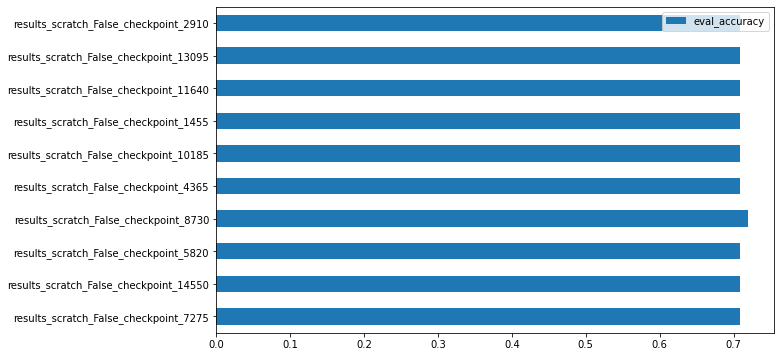

In [ ]:
print(res_df.loc[[c for c in res_df.index.to_list() if "False" in c]].mean())
res_df.loc[[c for c in res_df.index.to_list() if "False" in c]].plot.barh(figsize=(10,6))
plt.show()

eval_accuracy    0.690625
dtype: float64


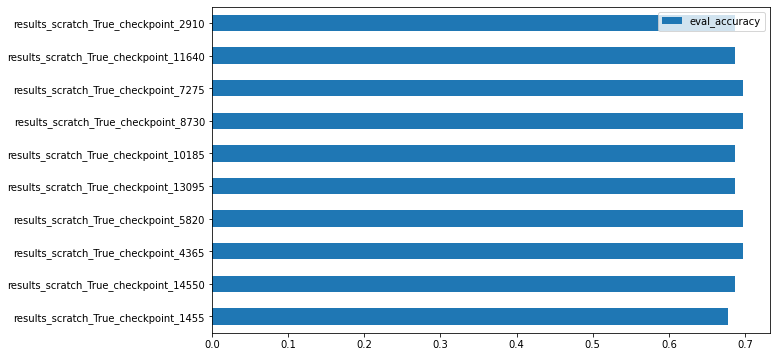

In [ ]:
print(res_df.loc[[c for c in res_df.index.to_list() if "True" in c]].mean())
res_df.loc[[c for c in res_df.index.to_list() if "True" in c]].plot.barh(figsize=(10,6))
plt.show()

## Uploading to HF Hub

In [ ]:
!pip install huggingface_hub

In [ ]:
!sudo apt-get install git-lfs

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  git-lfs
0 upgraded, 1 newly installed, 0 to remove and 39 not upgraded.
Need to get 2,129 kB of archives.
After this operation, 7,662 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 git-lfs amd64 2.3.4-1 [2,129 kB]
Fetched 2,129 kB in 0s (6,300 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package git-lfs.
(Reading database ... 155455 files and directories c

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import random
random.seed(0)
import glob

from transformers import AutoTokenizer
from transformers import AutoModelForMaskedLM

In [ ]:
%cd /content/COMP8730_research_project

/content/COMP8730_research_project


In [ ]:
!cp -r /content/drive/MyDrive/COMP8730_NLPU/results_scratch_true/ /content/COMP8730_research_project/results_scratch_True
!cp -r /content/drive/MyDrive/COMP8730_NLPU/results_scratch_false/ /content/COMP8730_research_project/results_scratch_False

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

Login successful
Your token has been saved to /root/.huggingface/token
Authenticated through git-credential store but this isn't the helper defined on your machine.
You might have to re-authenticate when pushing to the Hugging Face Hub. Run the following command in your terminal in case you want to set this credential helper as the default

git config --global credential.helper store


In [ ]:
for postfix_ in ["True", "False"]:
    sorted_files = sorted(
        glob.glob(
            f"/content/COMP8730_research_project/results_scratch_{postfix_}/*/checkpoint*"
        ),
        key=lambda x: int(x.split("-")[1]),
    )
    print(sorted_files[-1])

    if postfix_=="False":
        model_hub_name = "sanbert-from-indicbert"
    else:
        model_hub_name = "sanbert-from-scratch"

    tokenizer = AutoTokenizer.from_pretrained(sorted_files[-1])
    model = AutoModelForMaskedLM.from_pretrained(
            sorted_files[-1]
    )

    model.push_to_hub(model_hub_name, use_temp_dir=True)
    tokenizer.push_to_hub(model_hub_name, use_temp_dir=True)

/content/COMP8730_research_project/results_scratch_True/results_scratch_True/checkpoint-14550


/usr/local/lib/python3.7/dist-packages/huggingface_hub/utils/_deprecation.py:43: FutureWarning: Pass token='sanbert-from-scratch' as keyword args. From version 0.7 passing these as positional arguments will result in an error
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/huggingface_hub/hf_api.py:599: FutureWarning: `create_repo` now takes `token` as an optional positional argument. Be sure to adapt your code!
  FutureWarning,
Cloning https://huggingface.co/surajp/sanbert-from-scratch into local empty directory.


Download file pytorch_model.bin:   0%|          | 3.47k/128M [00:00<?, ?B/s]

Download file tokenizer.json:   0%|          | 16.0k/14.6M [00:00<?, ?B/s]

Download file spiece.model:   0%|          | 16.0k/5.38M [00:00<?, ?B/s]

Clean file spiece.model:   0%|          | 1.00k/5.38M [00:00<?, ?B/s]

Clean file tokenizer.json:   0%|          | 1.00k/14.6M [00:00<?, ?B/s]

Clean file pytorch_model.bin:   0%|          | 1.00k/128M [00:00<?, ?B/s]

Upload file pytorch_model.bin:   0%|          | 3.34k/126M [00:00<?, ?B/s]

To https://huggingface.co/surajp/sanbert-from-scratch
   e651c27..8dbd69f  main -> main

/usr/local/lib/python3.7/dist-packages/huggingface_hub/utils/_deprecation.py:43: FutureWarning: Pass token='sanbert-from-scratch' as keyword args. From version 0.7 passing these as positional arguments will result in an error
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/huggingface_hub/hf_api.py:599: FutureWarning: `create_repo` now takes `token` as an optional positional argument. Be sure to adapt your code!
  FutureWarning,
Cloning https://huggingface.co/surajp/sanbert-from-scratch into local empty directory.


Download file pytorch_model.bin:   0%|          | 3.48k/126M [00:00<?, ?B/s]

Download file spiece.model:   0%|          | 15.6k/5.38M [00:00<?, ?B/s]

Download file tokenizer.json:   0%|          | 1.58k/14.6M [00:00<?, ?B/s]

Clean file spiece.model:   0%|          | 1.00k/5.38M [00:00<?, ?B/s]

Clean file tokenizer.json:   0%|          | 1.00k/14.6M [00:00<?, ?B/s]

Clean file pytorch_model.bin:   0%|          | 1.00k/126M [00:00<?, ?B/s]

/content/COMP8730_research_project/results_scratch_False/results_scratch_False/checkpoint-14550


/usr/local/lib/python3.7/dist-packages/huggingface_hub/utils/_deprecation.py:43: FutureWarning: Pass token='sanbert-from-indicbert' as keyword args. From version 0.7 passing these as positional arguments will result in an error
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/huggingface_hub/hf_api.py:599: FutureWarning: `create_repo` now takes `token` as an optional positional argument. Be sure to adapt your code!
  FutureWarning,
Cloning https://huggingface.co/surajp/sanbert-from-indicbert into local empty directory.


Upload file pytorch_model.bin:   0%|          | 3.34k/126M [00:00<?, ?B/s]

To https://huggingface.co/surajp/sanbert-from-indicbert
   bf627d3..617e3cb  main -> main

/usr/local/lib/python3.7/dist-packages/huggingface_hub/utils/_deprecation.py:43: FutureWarning: Pass token='sanbert-from-indicbert' as keyword args. From version 0.7 passing these as positional arguments will result in an error
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/huggingface_hub/hf_api.py:599: FutureWarning: `create_repo` now takes `token` as an optional positional argument. Be sure to adapt your code!
  FutureWarning,
Cloning https://huggingface.co/surajp/sanbert-from-indicbert into local empty directory.


Download file pytorch_model.bin:   0%|          | 3.47k/126M [00:00<?, ?B/s]

Clean file pytorch_model.bin:   0%|          | 1.00k/126M [00:00<?, ?B/s]

Adding files tracked by Git LFS: ['tokenizer.json']. This may take a bit of time if the files are large.


Upload file tokenizer.json:   0%|          | 3.34k/14.6M [00:00<?, ?B/s]

Upload file spiece.model:   0%|          | 3.34k/5.38M [00:00<?, ?B/s]

To https://huggingface.co/surajp/sanbert-from-indicbert
   617e3cb..425301d  main -> main

